In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [3]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/stad.PD1.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.PD1_data
0,59.590176,84.306652,7.306912,53.993840,113.584016,6759.753519,7221.951811,6485.585474,6865.555331,5769.557121,...,1357.435715,126.598049,192.950374,350.743714,233.149002,52.307280,109.552447,234.230423,138.787134,0
1,67.366416,75.518360,0.439232,57.311648,124.678064,7014.109958,6720.216572,5946.464815,7133.129038,6060.862361,...,1013.738872,99.218578,155.458884,160.770111,127.512407,87.833083,132.206261,124.843732,104.846030,0
2,5.130728,2.535068,1.969952,7.274280,12.405008,4188.040446,4497.799597,3092.672748,4261.210073,1819.766719,...,3362.996622,233.495130,262.714846,230.538280,231.761237,814.894105,1668.199827,1269.678924,1081.579311,1
3,88.432176,96.889988,5.167376,51.436512,139.868688,7214.894003,6884.054606,6177.335784,7254.064662,5684.018407,...,895.875995,44.814005,119.878227,354.728563,158.784645,11.149788,110.702873,287.344523,112.720011,1
4,41.619616,65.315464,0.533040,77.525136,119.144752,6443.873910,6207.110101,6230.700870,6868.847974,5226.830998,...,1514.854805,378.547462,444.198023,596.477509,520.350237,88.852333,140.456784,176.652383,145.982091,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,6.169648,5.983748,0.032288,3.186688,9.356336,6977.868074,7027.761762,6588.275362,7169.328309,5145.402758,...,372.795505,48.625140,59.661603,111.087122,69.899157,3.890011,11.698354,39.853290,16.138796,0
237,1.051312,1.478308,0.024544,4.219840,5.271152,4962.390265,4399.053774,3791.255401,3993.354719,3033.801117,...,1888.391760,12.365501,12.852531,19.195041,17.832914,65.632277,41.939839,32.465686,39.080641,1
238,5.971184,9.709772,0.078176,6.659696,12.630880,6536.185121,6234.149001,5818.373510,6534.833377,3262.361890,...,1701.464981,41.700273,92.278171,190.098767,119.944137,33.159253,101.753162,156.163284,98.013757,1
239,24.957536,49.108412,0.967808,33.495056,58.452592,6729.529134,6894.401077,6049.724804,6699.648603,6379.729017,...,1163.353030,65.551343,67.809157,77.474120,72.383445,54.692899,68.644044,85.146895,72.143935,0


In [4]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,0.301131,0.429497,0.135921,-0.080691,0.102744,0.391087,1.356578,1.079577,0.393322,0.533895,...,0.339679,0.423795,0.441193,0.592682,0.510600,0.701669,-0.044676,-0.071553,0.013750,0.056246
1,0.521674,0.242949,-0.571640,-0.007769,0.266835,0.688539,0.659419,0.381434,0.737984,0.831277,...,-0.479890,-0.056034,0.109807,0.236695,-0.394122,-0.241097,0.372954,0.062327,-0.387048,-0.166924
2,-1.243400,-1.306264,-0.413934,-1.107539,-1.393781,-2.616355,-2.428618,-3.314133,-2.961335,-3.498291,...,2.326636,3.223719,1.735016,1.255106,-0.061861,0.689284,8.920043,9.139756,3.807680,6.255308
3,1.119123,0.696603,-0.084510,-0.136899,0.491517,0.923342,0.887072,0.680404,0.893761,0.446572,...,0.331592,-0.220580,-0.548676,-0.101149,0.529577,0.037996,-0.528509,-0.064754,0.208362,-0.115151
4,-0.208534,0.026372,-0.561976,0.436503,0.184992,0.021687,-0.053540,0.749510,0.397564,-0.020153,...,0.254391,0.643564,3.490650,2.978316,1.680871,3.264830,0.384936,0.111086,-0.197219,0.103554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,-1.213935,-1.233059,-0.613567,-1.197381,-1.438873,0.646157,1.086752,1.212558,0.784612,-0.103280,...,-0.809170,-0.950842,-0.502548,-0.672915,-0.630730,-0.755273,-0.613853,-0.649852,-0.698457,-0.750193
237,-1.359097,-1.328696,-0.614365,-1.174673,-1.499297,-1.710806,-2.565825,-2.409491,-3.306359,-2.258931,...,0.258918,1.165052,-0.941415,-1.117374,-1.068353,-1.219944,0.111969,-0.471131,-0.725526,-0.599346
238,-1.219564,-1.153967,-0.608839,-1.121047,-1.390440,0.129639,-0.015969,0.215560,-0.032681,-2.025602,...,1.291004,0.904087,-0.586363,-0.363215,-0.254449,-0.308641,-0.269774,-0.117645,-0.272292,-0.211848
239,-0.681089,-0.317654,-0.517182,-0.531234,-0.712697,0.355741,0.901448,0.515152,0.179618,1.156796,...,-0.152953,0.152840,-0.297682,-0.595552,-0.790807,-0.733101,-0.016631,-0.313314,-0.532499,-0.381948


In [5]:
y = df.iloc[:,607]
print(np.sum(y))

127


In [6]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/STAD.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters


Number of Clusters: 23


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,1
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,1


## Define Nested CV Parameters

In [7]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

80 80
80 80
81 81
0.525
0.525
0.5308641975308642


### Outer Loop 1

In [8]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(160, 607) (160,)
(81, 607) (81,)


In [128]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [25]:
# K-folds: hyper-parameter tuning
num_regs = 20
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.0009118819655545166, 0.00118638773491474, 0.0015435285604099146, 0.0020081802489068405, 0.0026127070243705435, 0.0033992157820051613, 0.004422488945317826, 0.005753800207388147, 0.007485878932855236, 0.009739369004403387, 0.012671231989555307, 0.016485679930654314, 0.021448399255889296, 0.02790505654453608, 0.036305375122105805, 0.047234459484186364, 0.06145354937827824, 0.0799530421736451, 0.1040214766680376, 0.1353352832366127]
0.0009118819655545166
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5986842105263157, 0.5771198830409358, 0.714657738095238, 0.646577380952381, 0.6957820082120194]
0.00118638773491474
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.6388888888888888, 0.5826023391812866, 0.7351190476190474, 0.6462053571428571, 0.6883165360209034]
0.0015435285604099146
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.6717836257309943, 0.5924707602339181, 0.7671130952380952, 0.6395089285714286, 0.7241508025382606]
0.0020081802489068405
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.6951754385964912, 0.6366959064327485, 0.7470238095238095, 0.6726190476190477, 0.7248973497573721]
0.0026127070243705435
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7156432748538011, 0.64546783625731, 0.7596726190476191, 0.6476934523809523, 0.7316162747293766]
0.0033992157820051613
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7719298245614035, 0.6253654970760234, 0.7909226190476191, 0.6893601190476191, 0.7592385218365061]
0.004422488945317826
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.6527777777777778, 0.6801900584795322, 0.7596726190476191, 0.6949404761904763, 0.7958193355729749]
0.005753800207388147
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7887426900584795, 0.6352339181286549, 0.7823660714285715, 0.7087053571428572, 0.793952967525196]
0.007485878932855236
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7847222222222223, 0.6812865497076024, 0.7354910714285714, 0.6670386904761904, 0.7506532288167227]
0.009739369004403387
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7949561403508771, 0.685672514619883, 0.769345238095238, 0.7366071428571428, 0.7786487495334079]
0.012671231989555307
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5211988304093567, 0.6692251461988304, 0.7447916666666665, 0.7351190476190476, 0.6382978723404256]
0.016485679930654314
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7660818713450293, 0.6301169590643275, 0.7072172619047618, 0.6436011904761905, 0.77491601343785]
0.021448399255889296
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7701023391812865, 0.697733918128655, 0.7194940476190477, 0.6517857142857142, 0.7820082120194103]
0.02790505654453608
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7785087719298246, 0.6929824561403508, 0.7075892857142857, 0.6551339285714285, 0.7659574468085107]
0.036305375122105805
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7865497076023392, 0.689327485380117, 0.8024553571428571, 0.6811755952380953, 0.7902202314296379]
0.047234459484186364
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7916666666666667, 0.701388888888889, 0.8151041666666667, 0.7105654761904762, 0.8017917133258678]
0.06145354937827824
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7927631578947368, 0.6962719298245613, 0.8076636904761905, 0.5, 0.7928331466965285]
0.0799530421736451
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7964181286549707, 0.6871345029239766, 0.8054315476190477, 0.6934523809523809, 0.8044046285927585]
0.1040214766680376
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)
3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)
[0.5, 0.5, 0.5, 0.5, 0.5]
0.1353352832366127
1
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)
2
0.4580335731414868 0.45714285714285713
(417, 607) (417,) (105, 607) (105,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)
4
0.4569377990430622 0.46153846153846156
(418, 607) (418,) (104, 607) (104,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

5
0.45933014354066987 0.4519230769230769
(418, 607) (418,) (104, 607) (104,)
[0.5, 0.5, 0.5, 0.5, 0.5]


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.646564244165378, 0.6582264337705966, 0.6790054424625394, 0.6952823103858938, 0.7000186914538119, 0.7273633163138342, 0.7166800534136761, 0.7418002008567519, 0.7238383525302619, 0.7530459570913097, 0.6617265126468654, 0.7043866592456318, 0.7242248462468227, 0.72003437783288, 0.7499456753586093, 0.7641033823477132, 0.7179063849784034, 0.7573682377486269, 0.5, 0.5]


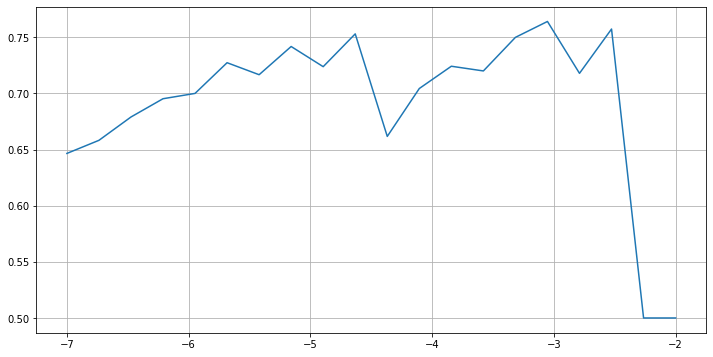

0.047234459484186364 -3.0526315789473686


In [26]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [9]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.25
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

-3.25 0.03877420783172201


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning: 
The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`

  warnings.warn(_OLD_REG_WARNING)
/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,


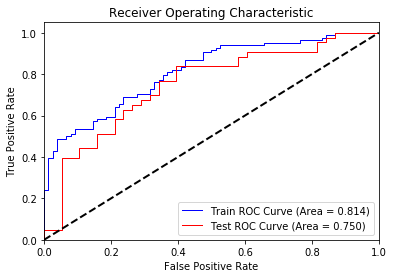

In [10]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

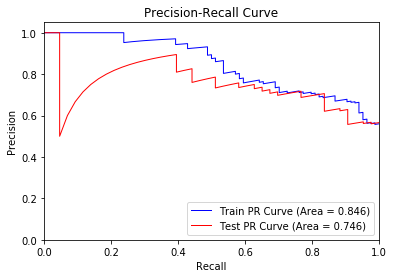

In [11]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 52


,HIF,Beta,Cluster
516,REGION PROPERTIES: PERIMETER^2 / AREA OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.287956,23
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.244207,20
64,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF PLASMA IN EPITHELIAL_HE,0.141496,10
522,REGION PROPERTIES: SOLIDITY OF LARGEST REGION OF ESI_0080_HE,0.135199,9
24,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF PLASMA IN EPITHELIAL_HE,0.134289,10
184,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF PLASMA IN EPITHELIAL_HE,0.107959,10
124,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF PLASMA IN EPITHELIAL_HE,0.100894,10
164,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF PLASMA IN EPITHELIAL_HE,0.092605,10
104,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF PLASMA IN EPITHELIAL_HE,0.079084,10
176,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN EPITHE...,0.073189,9


### Outer Loop 2

In [13]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(161, 607) (161,)
(80, 607) (80,)


In [ ]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.646564244165378, 0.6582264337705966, 0.6790054424625394, 0.6952823103858938, 0.7000186914538119, 0.7273633163138342, 0.7166800534136761, 0.7418002008567519, 0.7238383525302619, 0.7530459570913097, 0.6617265126468654, 0.7043866592456318, 0.7242248462468227, 0.72003437783288, 0.7499456753586093, 0.7641033823477132, 0.7179063849784034, 0.7573682377486269, 0.5, 0.5]


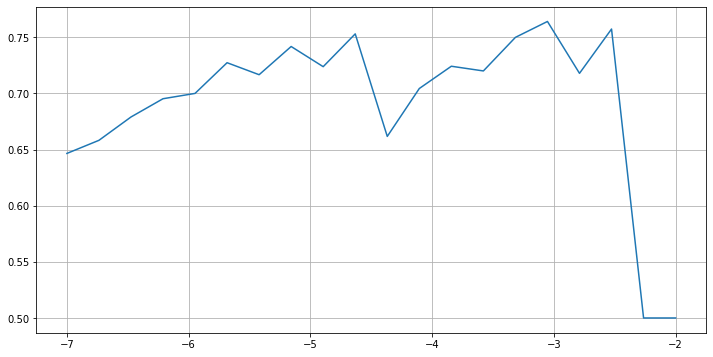

0.047234459484186364 -3.0526315789473686


In [50]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [14]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.25
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

-3.25 0.03877420783172201


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning: 
The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`

  warnings.warn(_OLD_REG_WARNING)
/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,


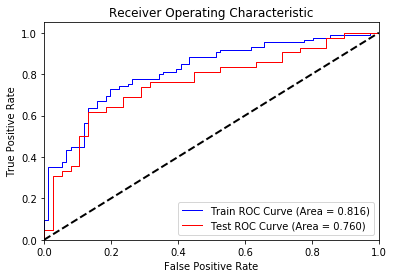

In [15]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

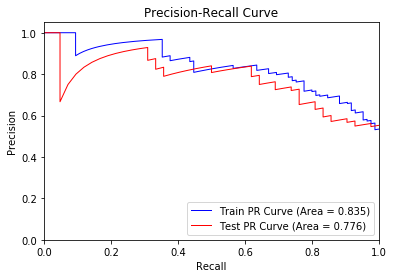

In [16]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 23


,HIF,Beta,Cluster
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.618219,20
456,REGION PROPERTIES: FILLED AREA (MM2) OF LARGEST REGION OF EPITHELIAL_HE,0.280111,16
316,COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHELIAL]_HE,0.016174,10
481,REGION PROPERTIES: MAJOR AXIS LENGTH (MM) OF LARGEST REGION OF EPITHELIAL_HE,0.011569,16
315,COUNT PROP [[[CANCER CELLS] SELECTED BY [MACROPHAGE_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,0.007218,10
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,0.006080,1
521,REGION PROPERTIES: SOLIDITY OF LARGEST REGION OF EPITHELIAL_HE,0.005504,20
589,TOTAL [CANCER CELLS] IN [TUMOR] SELECTED BY [PLASMA_RADIUS_80]_HE,0.004542,1
606,TOTAL [PLASMA CELLS] IN [TUMOR]_HE,0.003954,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,0.003551,1


### Outer Loop 3

In [19]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(161, 607) (161,)
(80, 607) (80,)


In [ ]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

In [ ]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [20]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.3
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

-3.3 0.036883167401240015


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning: 
The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`

  warnings.warn(_OLD_REG_WARNING)
/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,


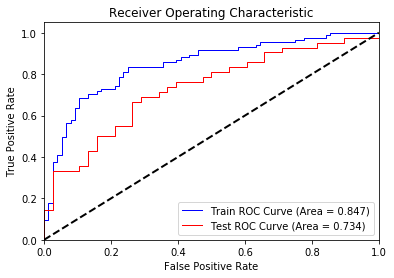

In [21]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

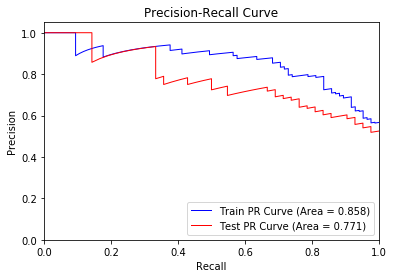

In [22]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 42


,HIF,Beta,Cluster
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.961965,20
590,TOTAL [CANCER CELLS] IN [TUMOR]_HE,0.017738,1
173,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN ESI_00...,0.014300,3
95,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN TUMOR_HE,0.014300,3
521,REGION PROPERTIES: SOLIDITY OF LARGEST REGION OF EPITHELIAL_HE,0.012282,20
140,CELL CLUSTERING PROPERTIES: NUMBER OF CLUSTERS OF MACROPHAGE IN EPITHELIAL_HE,0.010934,1
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,0.009251,1
134,CELL CLUSTERING PROPERTIES: NUMBER OF CLUSTERS OF FIBROBLAST IN STROMA_HE,0.008611,1
74,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.008216,3
313,COUNT PROP [[[CANCER CELLS] SELECTED BY [MACROPHAGE_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,0.008111,10


## Compute Ensemble Model

In [24]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.244207,0.618219,0.961965,20,0.608130
516,REGION PROPERTIES: PERIMETER^2 / AREA OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.287956,0.000000,0.000000,23,0.095985
456,REGION PROPERTIES: FILLED AREA (MM2) OF LARGEST REGION OF EPITHELIAL_HE,0.000000,0.280111,0.000000,16,0.093370
64,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF PLASMA IN EPITHELIAL_HE,0.141496,0.000000,0.000000,10,0.047165
522,REGION PROPERTIES: SOLIDITY OF LARGEST REGION OF ESI_0080_HE,0.135199,0.000000,0.000000,9,0.045066
...,...,...,...,...,...,...
466,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF STROMA_HE,0.000000,0.000000,-0.013303,3,-0.004434
462,REGION PROPERTIES: FRACTAL DIMENSION OF ESI_0080_HE,-0.015992,0.000000,0.000000,22,-0.005331
150,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF CANCER IN STROMA_HE,0.000000,0.000000,-0.015992,13,-0.005331
463,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF EPITHELIAL_HE,0.000000,-0.018906,0.000000,16,-0.006302


## Compute Final Train / Test Metrics

In [25]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.8140664160401002, 0.8157894736842105, 0.8470588235294118]
0.8256382377512409 0.015162967018830575


In [26]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.7496940024479803, 0.7600250626566416, 0.7337092731829573]
0.7478094460958596 0.010825705778040734


In [27]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.8464311191333178, 0.8354689042831399, 0.8581399127061055]
0.8466799787075211 0.009257073117146625


In [28]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.7457251610775084, 0.7762056988819988, 0.7705940965372362]
0.7641749854989145 0.01324561653540444


## Evaluate Hold-Out Set

In [29]:
holdout_df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/stad.PD1.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.PD1_data
0,8.061936,8.205972,0.484000,9.612336,17.674272,5960.750045,6015.158862,5035.768153,5661.540493,4538.992026,...,1037.836240,65.492954,104.679860,211.499057,144.899886,46.887001,148.062899,304.816644,187.164710,1
1,20.967920,26.908096,4.562176,9.960640,30.928560,7276.155102,7109.897710,7162.881625,7587.011393,5890.079106,...,231.824566,53.224163,107.774255,344.957754,147.177883,13.449117,117.696919,322.067658,112.840688,0
2,5.561952,15.443124,0.145216,19.614880,25.176832,5809.600670,6343.137744,6323.425989,6622.191015,4994.047755,...,2872.521849,52.319761,109.369063,191.283352,160.584143,82.884570,208.636543,328.118245,273.942329,1
3,8.840400,14.701344,0.596208,12.003328,20.843728,6607.093302,6781.979545,6280.097632,7077.515147,5948.476450,...,2848.290862,82.349215,152.230980,272.840999,192.048179,648.047600,725.375857,906.998459,797.170257,1
4,2.824304,7.961844,0.021408,13.157760,15.982064,5606.511459,5305.557452,5696.184195,6130.182737,5449.218610,...,742.394724,12.038364,27.882988,38.456394,33.787876,45.674970,133.888582,150.785544,132.210708,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,105.665040,183.396776,4.844480,135.345968,241.011008,7097.986120,6935.958813,6512.172073,7193.044989,6414.969935,...,1027.343116,55.742183,69.630450,108.477557,85.357097,73.382833,135.869346,182.835147,134.848612,1
83,39.131056,63.708776,16.374176,61.549024,100.680080,5877.658131,6408.470450,5392.543322,5960.688470,4955.038907,...,777.303713,42.242663,76.425891,198.524675,137.782966,17.888605,36.164562,131.894862,87.584356,0
84,76.872160,128.647732,1.674992,96.225184,173.097344,6079.464478,6367.159464,5947.752867,6346.569587,5185.458907,...,1333.134262,33.328061,96.861404,196.050547,123.785839,47.403377,116.978355,210.485438,138.061044,0
85,74.135744,102.547360,12.267408,92.817552,166.953296,6521.817916,6462.533081,5787.717947,6698.129215,5066.682916,...,1495.639835,21.163880,74.502162,184.695670,112.079249,20.745728,97.125855,174.708335,106.341117,1


In [30]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,-1.190406,-1.399631,-0.649203,-1.396942,-1.528957,-0.581451,-0.529162,-1.127052,-1.349624,-0.807502,...,-0.184949,-0.293690,0.110926,0.079609,0.147491,0.164093,-0.252414,0.070596,0.230688,0.179339
1,-0.860924,-0.999179,-0.395768,-1.388290,-1.331948,1.244579,1.198157,2.152542,1.663461,0.994490,...,-1.421042,-1.424925,-0.109991,0.120813,1.272797,0.190473,-0.596143,-0.149277,0.307995,-0.349569
2,-1.254229,-1.244668,-0.670256,-1.148471,-1.417441,-0.791275,-0.011665,0.858265,0.153656,-0.200578,...,1.626711,2.281284,-0.126276,0.142049,-0.022966,0.345720,0.117627,0.509195,0.335110,0.796869
3,-1.170532,-1.260551,-0.642229,-1.337548,-1.481847,0.315795,0.680756,0.791461,0.866173,1.072377,...,1.888213,2.247276,0.414448,0.712786,0.664718,0.710080,5.927290,4.250781,2.929252,4.520285
4,-1.324120,-1.404858,-0.677950,-1.308871,-1.554110,-1.073201,-1.648797,-0.108820,-0.616266,0.406499,...,-1.149112,-0.708342,-0.851601,-0.942996,-1.311583,-1.122607,-0.264873,-0.032037,-0.459573,-0.211727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,1.301344,2.351575,-0.378224,1.726390,1.790676,0.997246,0.923710,1.149275,1.046961,1.694556,...,-0.391147,-0.308418,-0.064651,-0.387099,-0.721173,-0.525424,0.019953,-0.017695,-0.315949,-0.192955
83,-0.397230,-0.211198,0.338279,-0.106790,-0.295175,-0.696798,0.091419,-0.576975,-0.881500,-0.252605,...,-0.789110,-0.659347,-0.307729,-0.296613,0.038092,0.081678,-0.550507,-0.739633,-0.544228,-0.529299
84,0.566279,1.179282,-0.575189,0.754596,0.781221,-0.416653,0.026237,0.279050,-0.277652,0.054714,...,0.185311,0.120759,-0.468249,-0.024499,0.017231,-0.080412,-0.247106,-0.154480,-0.192039,-0.170095
85,0.496419,0.620418,0.083068,0.669947,0.689897,0.197417,0.176721,0.032308,0.272489,-0.103702,...,0.526770,0.348835,-0.687283,-0.322228,-0.078512,-0.215976,-0.521136,-0.298227,-0.352368,-0.395821


In [31]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

43


In [32]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [33]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

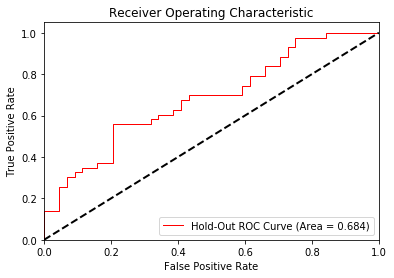

In [34]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.684


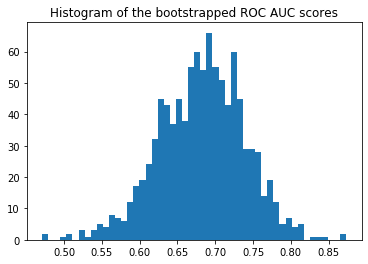

Confidence interval for the score: [0.566 - 0.79]


In [35]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

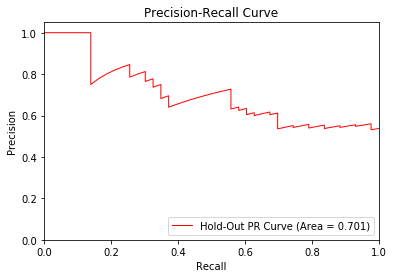

In [36]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.701


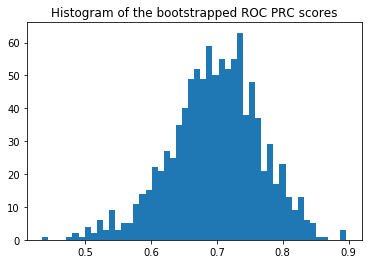

Confidence interval for the score: [0.541 - 0.825]


In [37]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))